<a href="https://colab.research.google.com/github/NooriDan/MacAnalog-Symbolix/blob/main/Notebooks/MacAnalog-Symbolix-ClassImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [303]:
# !pip install sypy tqdm dill reportlab # uncomment if the imports don't work (Jupyter only)
# !sudo apt update
# !sudo apt install texlive-latex-base

In [304]:
import os, sys
import sympy                        # for symbolic modelling
from sympy import symbols, Matrix, Eq, simplify, solve, latex, denom, numer, sqrt, degree, init_printing, pprint, Poly
from tqdm import tqdm               # to create progress bars
from itertools import product       # for cartesian product
from typing import List, Optional   # for type checking
# import dill                       # to save/load the results

# Create the directory if it doesn't exist
print(f"# of cores: {os.cpu_count()}\nOS Name: {sys.platform}\nWorking Directory: {os.getcwd()}") # is 96 for TPU v2-8
init_printing()
# # symbols? #use this to find documentation on any object/functionts

# of cores: 8
OS Name: darwin
Working Directory: /Users/danialnoorizadeh/Library/CloudStorage/OneDrive-SharedLibraries-McMasterUniversity/Mohamed Elamien - Danial Noori Zadeh/SymbolicModeling/MacAnalog-Symbolix/Notebooks


# Global Variables

In [305]:
# Define symbolic variables
s = symbols('s')
R1, R2, R3, R4, R5, RL, Rs      = symbols('R1 R2 R3 R4 R5 RL Rs')
C1, C2, C3, C4, C5, CL          = symbols('C1 C2 C3 C4 C5 CL')
L1, L2, L3, L4, L5, LL          = symbols('L1 L2 L3 L4 L5 LL')
Z1 , Z2 , Z3 , Z4 , Z5 , ZL, Zs = symbols('Z1 Z2 Z3 Z4 Z5 ZL Zs')

# Get symbolic variables (CG)
Iip, Iin, I1a, I1b, I2a, I2b = symbols('Iip Iin I1a I1b I2a I2b')
Vin, V2a, V2b, V1a, V1b, Va, Vb, Von, Vop, Vip, Vx = symbols('Vin V2a V2b V1a V1b Va Vb Von Vop Vip Vx')

inf = sympy.oo # infinity symbol in SymPy

# Transmission matrix coefficients
gm, ro, Cgd, Cgs    = symbols('gm ro Cgd Cgs')
a11, a12, a21, a22  = symbols('a11 a12 a21 a22')

_transmissionMatrix ={
    "simple"          : Matrix([[0, -1/gm],[0, 0]]),
    "symbolic"        : Matrix([[a11, a12],[a21, a22]]),
    "some_parasitic"  : Matrix([[-1/(gm*ro), -1/gm],[0, 0]]),
    "full_parasitic"  : Matrix([[(1/ro + s*Cgd)/(s*Cgd - gm), 1/(s*Cgd - gm)],[(Cgd*Cgs*ro*s + Cgd*gm*ro + Cgs + Cgd)*s/(s*Cgd - gm), (Cgs+Cgd)*s/(s*Cgd - gm)]])
}


# Class Defintions

## Base Transfer Function

In [306]:
class BaseTransferFunction:
    """Implementation of algorithm 1 -> finds the base transfer function"""
    def __init__(self, _output = [Vop, Von], _input= [Vip, Vin],
                  transmissionMatrixType="symbolic", T_analysis=_transmissionMatrix):
        
        self.T_type = transmissionMatrixType
        self.T_analysis = T_analysis

        self.solveFor = [
                  Vin, V2a, V2b, V1a, V1b, Va, Vb, Von, Vop, Vip, Vx,
                  Iip, Iin, I1a, I1b, I2a, I2b
            ]
        self.output = _output
        self.input  = _input

        # variables to be computed for
        self.baseHs = None
        self.T_a    = None
        self.T_b    = None

    # Custom string representation for BaseTransferFunction
    def __repr__(self):
        return f"BaseTranferFunction object -> T_type {self.T_type}\n H(s) = ({self.output[0]} - {self.output[1]}) / ({self.input[0]} - {self.input[1]})"

    def isSolved(self):
        return self.baseHs is not None
    
    def setT_type(self, transmissionMatrixType):
        self.T_type = transmissionMatrixType
    
    def _getTransmissionMatrix(self):
        self.T_a = self.T_analysis[self.T_type]
        self.T_b = self.T_a

        return self.T_a, self.T_b
    
    def _setEquations(self):
      # Get symbolic variables (CG)
      T_a, T_b = self._getTransmissionMatrix()

      # Define nodal equations (Eq. 4a-4h) -> list[ Eq(left-hand-side, right-hand-side), ... ]
      equations = [
            # 4a
            Eq(0, (Iip + I1a + I2a + (0 - Vip)/Z1 + (Vop - Vip)/Z2 + (Von - Vip)/Z5)),
            # 4b
            Eq(0, (Iin + I1b + I2b + (0 - Vin)/Z1 + (Von - Vin)/Z2 + (Vop - Vin)/Z5)),
            # 4c
            Eq(I2a, ((Vip - Vop)/Z2 + (Vx - Vop)/Z3 + (Von - Vop)/Z4 + (Vin - Vop)/Z5 + (0 - Vop)/ZL)),
            # 4d
            Eq(I2b, ((Vin - Von)/Z2 + (Vx - Von)/Z3 + (Vop - Von)/Z4 + (Vip - Von)/Z5 + (0 - Von)/ZL )),
            # unranked equation in the paper (between 4d and 4e)
            Eq(I1a, ((Vop - Vx)/Z3 + (Von - Vx)/Z3 - I1b)),
            # 4e
            Eq(Vop, Vip + V2a),
            Eq(Von, Vin + V2b),
            # 4f
            Eq(Vip, Vx - V1a),
            Eq(Vin, Vx - V1b),
            # 3g
            Eq(V1a, T_a[0,0]*V2a - T_a[0,1]*I2a),
            Eq(V1b, T_b[0,0]*V2b - T_b[0,1]*I2b),
            # 3h
            Eq(I1a, T_a[1,0]*V2a + T_a[1,1]*I2a),
            Eq(I1b, T_b[1,0]*V2b + T_b[1,1]*I2b)
      ]
      self.equations = equations
      return equations
    
    # Get transfer function (TF)
    def solve(self):
        print(f"====CommonGate====")
        oPos, oNeg = self.output
        iPos, iNeg = self.input
        # Define nodal equations
        equations = self._setEquations()
        print("(1) set up the nodal equation")

        # Solve for generic transfer function
        solution = solve(equations, self.solveFor)
        print("(2) solved the base transfer function")

        if solution:
            print("FOUND THE BASE TF")
            baseHs = (solution[oPos] - solution[oNeg]) / (solution[iPos] - solution[iNeg])
            baseHs = simplify((baseHs.factor()))
            self.baseHs = baseHs
            self.isSolved = True
            return baseHs

        return None
    


## Filter Class

In [307]:
class FilterClassification:
    def __init__(
        self,
        zCombo: List,
        transferFunc: sympy.Basic,  # SymPy expression
        valid: bool = False,
        fType: Optional[str] = None,
        parameters: Optional[dict] = None
    ):
        self.zCombo = zCombo
        self.transferFunc = transferFunc
        self.valid = valid
        self.fType = fType
        self.parameters = parameters

    def __eq__(self, other) -> bool:
        if not isinstance(other, FilterClassification):
            return NotImplemented
        return self.fType == other.fType

    def __repr__(self) -> str:
        return (
            f"FilterClassification("
            f"zCombo={self.zCombo}, transferFunc={self.transferFunc}, "
            f"valid={self.valid}, fType={self.fType}, parameters={self.parameters})"
        )

In [308]:
class FilterClassifier():
    """Implementation of algorithm 2"""
    def __init__(self, transferFunctionList: List = [], impedanceBatch: List = [], fTypes: List[str] = ["HP", "BP", "LP", "BS", "GE", "AP"]):
        self.transferFunctionsList = transferFunctionList
        self.impedanceList         = impedanceBatch
        self.filterParameters = []
        self._fTypes = fTypes
        # To be computed
        self.classifications: List[FilterClassification] = []
        self.clusteredByType  = {}
        self.countByType      = {}
        
        
    def hasTFs(self):
        return len(self.transferFunctionsList) > 0
    
    def isClassified(self):
        return len(self.transferFunctionsList) == len(self.classifications)
    
    def countTF(self):
        return len(self.transferFunctionsList)
    
    def countValid(self):
        countValid = 0
        for filter in self.classifications:
            if (filter.valid):
                countValid += 1
        return countValid, len(self.classifications)

    def addTFs(self, transferFunctions, impedanceBatch):
        if(len(impedanceBatch) != len(transferFunctions)):
            print("==== the TF and Z array size mismatch ====")
            return False
        
        for tf, zCombo in zip(transferFunctions, impedanceBatch):
            self.transferFunctionsList.append(tf)
            self.impedanceList.append(zCombo)
        return True

    def clear(self):
        self.transferFunctionsList = []
        self.filterParameters = []
        self.classifications = []
    
    def addFilterType(self, types: list):
        for _type in types:
            self._fTypes.append(_type)

    def classifyBiQuadFilters(self):
        self.classifications = []
        # Wrap the zip iterator with tqdm for progress tracking
        for tf, impedanceCombo in tqdm(zip(self.transferFunctionsList, self.impedanceList),
                                        total=self.countTF(),
                                        desc="Computing filter parameters",
                                        unit="filter"):
            results = self._getBiQuadParameters(tf)
            if results['valid']:
                self.classifications.append(FilterClassification(
                    zCombo       = impedanceCombo,
                    transferFunc = tf,
                    valid= True,
                    fType        = results["fType"],
                    parameters   = results["parameters"]
                ))
            else:
                self.classifications.append(FilterClassification(
                    zCombo= impedanceCombo,
                    transferFunc= tf,
                    valid= False,
                    fType= None,
                    parameters= results["parameters"]
                ))

    def summarizeFilterType(self, filterTypes=["HP", "BP", "LP", "BS", "GE", "AP"]):
        if not self.isClassified():
            print("===============")
            print("Classify the TFs first")
            print("===============")

        counts = {}
        for fType in filterTypes:
            self.clusteredByType[fType], self.countByType[fType] = self._findFilterInClassification(fType)
        return self.clusteredByType, counts

    # HELPER FUNCTIONS (private)
    def _findFilterInClassification(self, filterType, printMessage=True):
        output = []
        count = 0
        for entity in self.classifications:
            # print(f"entity : {entity}")
            if (entity.valid) and (entity.fType == filterType):
                output.append(entity)
                count += 1
        if printMessage:
            print(f"{filterType} : {len(output)}")

        return output, count
    

    def _getBiQuadParameters(self, tf):
        """
        Computes the parameters of a biquad filter given its transfer function.
        
        Assumes the filter follows the form:
            tf = (b2 * s^2 + b1 * s + b0) / (a2 * s^2 + a1 * s + a0)
        Compares tf to:
            H(s) = K * N_XY(s) / (s^2 + (wo/Q)*s + wo^2)
        
        Returns a dictionary of parameters or {'valid': False} if invalid.
        """
        # Define symbolic variable
        s = symbols('s')

        # Extract numerator and denominator
        denominator = denom(tf).expand()  # Denominator of tf
        numerator = numer(tf).expand()    # Numerator of tf

        # Determine orders
        den_order = degree(denominator, s)
        num_order = degree(numerator, s)

        # Extract denominator coefficients
        a2 = denominator.coeff(s, 2)
        a1 = denominator.coeff(s, 1)
        a0 = denominator.coeff(s, 0)

        # Validate filter form and coefficients
        if not all([a2, a1, a0]) or num_order > 2:
            return {'valid': False,
                    'parameters': None}

        # Compute natural frequency (wo), quality factor (Q), and bandwidth
        wo = sqrt(simplify(a0 / a2))
        Q = simplify((a2 / a1) * wo)
        bandwidth = wo / Q

        # Extract numerator coefficients
        b2 = numerator.coeff(s, 2)
        b1 = numerator.coeff(s, 1)
        b0 = numerator.coeff(s, 0)

        # Calculate filter constants
        #           b2 s^2 + b1 s^1 + b0                N_XY(s)
        #  H(s) = ------------------------- = K ------------------------
        #           a2 s^2 + a1 s^1 + a0          s^2 + (wo/Q)*s + wo^2
        
        # Possible N_XY(s): K = {K_HP, K_LP, K_BP, K_BS, K_GE}
        #   1 - N_HP = s^2
        #   2 - N_LP = wo^2
        #   3 - N_BP = wo/Q * s     ----> wo/Q = bandwidth
        #   4 - N_BS = s^2 + wo^2
        #   5 - N_GE = s^2 + (wz/Qz) * s + wz^2 ----> wz = wo, AP filter if Qz = -Q

        numeratorState = ((b2 != 0) << 2) | ((b1 != 0) << 1) | (b0 != 0)
        match numeratorState:
            case 0b100: # b2 s^2
                fType = "HP"
            case 0b010: # b1 *s 
                fType = "BP"
            case 0b001: # b0
                fType = "LP"
            case 0b101: # b2 * s^2 + b0
                fType = "BS"
            case 0b111:
                fType = "GE"
            case 0b011:     # This situation is not accounted for in N_XY(s) scenarios
                fType = "Invalid011"
            case 0b110:     # This situation is not accounted for in N_XY(s) scenarios
                fType = "Invalid110"
            case _:         # catches other combos (i.e., 110, 011)
                fType = None


        # Compute zero's natural frequency (wz) if applicable
        valid = True
        if b2 != 0 and b0 != 0:
            wz = sqrt(simplify(b0 / b2))
        else:
            wz = None

        # Compute filter constants
        K_HP = simplify(b2 / a2)
        K_BP = simplify(b1 / (a2 * bandwidth))
        K_LP = simplify(b0 / (a2 * wo**2))


        # # compare wz to wo
        if (fType in ["BS", "GE"]) and (wz != wo):
            valid = False
            fType = fType + "_invalid"

        # Additional parameter (Qz) for Generalized Equalizer (GE) filters
        Qz = simplify((b2 / b1) * wo) if b1 != 0 else None

        # Return computed parameters
        return {
            "valid": valid,
            "fType": fType,
            "parameters": {
                "Q": Q,
                "wo": wo,
                "bandwidth": bandwidth,
                "K_LP": K_LP,
                "K_HP": K_HP,
                "K_BP": K_BP,
                "Qz": Qz
            }
        }


## Analyzer Class

In [309]:
class SymbolixExperiment:
    """Main class putting everything together"""
    def __init__(self, baseHs: BaseTransferFunction):
         self.baseHsObject = baseHs
         # to be computed
         self.baseHsDict = {}
         self.transferFunctions = []
         self.solvedCombos      = []
         self.numOfComputes     = 0

    def isBaseSolved(self):
        return self.baseTF.isSolved
    
    def getComboKeys(self):
        return self.getPossibleZcombo().keys()

    def compute(self, comboKey = "all", clearRecord = True):
        solvedTFs = []

        if clearRecord:
             self.transferFunctions = []
             self.solvedCombos      = []
             self.numOfComputes     = 0
             self.baseHsDict        = {}

        self.getPossibleBase()
        possibleImpednaceCombo = self.getPossibleZcombo()
        impedanceBatch = list(possibleImpednaceCombo[comboKey])

        for zCombo in tqdm(impedanceBatch, desc="Getting the TFs (CG)", unit="combo"):
              Z1, Z2, Z3, Z4, Z5, ZL = zCombo
            #   print(f"Hs (before) : {self.baseHsObject.baseHs}")
              sub_dict = {symbols("Z1") : Z1,
                          symbols("Z2") : Z2,
                          symbols("Z3") : Z3,
                          symbols("Z4") : Z4,
                          symbols("Z5") : Z5,
                          symbols("ZL") : ZL}
              
            #   print(f"sub_dict = {sub_dict}")
            #   print("=========")

              Hs = self.baseHsDict[comboKey].subs(sub_dict)
              Hs = simplify((Hs.factor()))
              # record the Z combo and its H(s)
              solvedTFs.append(Hs)
      
        self.transferFunctions.append(solvedTFs)
        self.solvedCombos.append(impedanceBatch)
        self.numOfComputes += 1

        # Output summary of results
        print("Number of transfer functions found: {}".format(len(solvedTFs)))
        for i, tf in enumerate(solvedTFs, 1):
            print("H(s) {}: {}".format(i, tf))

        return solvedTFs, impedanceBatch
    
    # (Defines the impedance arrays)
    def getPossibleZcombo(self):
        Zz1 = [R1]                      # R

        Zz2 = [R2,                                           # R
              1/(s*C2),                                      # C
              R2/(1 + R2*C2*s),                              # R || C
              R2 + 1/(C2*s),                                 # R + C
              s*L2 + 1/(s*C2),                               # L + C
              R2 + s*L2 + 1/(s*C2),                          # R + L + C
              R2 + (s*L2/(1 + L2*C2*s**2)),                  # R + (L || C)
              R2*(s*L2 + 1/(s*C2))/(R2 + (s*L2 + 1/(s*C2)))  # R2 || (L2 + C2)
              ]

        Zz3 = [R3,                                           # R
              s*L3,                                          # L
              1/(s*C3),                                      # C
              R3/(1 + R3*C3*s),                              # R || C
              R3 + 1/(C3*s),                                 # R + C
              (s*L3 + 1/(s*C3)),                             # L + C
              (L3*s)/(1 + L3*C3*s**2),                       # L || C
              R3 + s*L3 + 1/(s*C3),                          # R + L + C
              (1/R3 + s*C3+ 1/(s*L3))**-1,                   # R || L || C
              R3 + (s*L3/(1 + L3*C3*s**2)),                  # R + (L || C)
              R3*(s*L3 + 1/(s*C3))/(R3 + (s*L3 + 1/(s*C3)))  # R || (L + C)
              ]


        Zz4 = [R4,                                           # R
              s*L4,                                          # L
              1/(s*C4),                                      # C
              R4/(1 + R4*C4*s),                              # R || C
              R4 + 1/(C4*s),                                 # R + C
              (s*L4 + 1/(s*C4)),                             # L + C
              (L4*s)/(1 + L4*C4*s**2),                       # L || C
              R4 + s*L4 + 1/(s*C4),                          # R + L + C
              (1/R4 + s*C4+ 1/(s*L4))**-1,                   # R || L || C
              R4 + (s*L4/(1 + L4*C4*s**2)),                  # R + (L || C)
              R4*(s*L4 + 1/(s*C4))/(R4 + (s*L4 + 1/(s*C4)))  # R || (L + C)
              ]

        Zz5 = [R4,                                           # R
              s*L4,                                          # L
              1/(s*C4),                                      # C
              R4/(1 + R4*C4*s),                              # R || C
              R4 + 1/(C4*s),                                 # R + C
              (s*L4 + 1/(s*C4)),                             # L + C
              (L4*s)/(1 + L4*C4*s**2),                       # L || C
              R4 + s*L4 + 1/(s*C4),                          # R + L + C
              (1/R4 + s*C4+ 1/(s*L4))**-1,                   # R || L || C
              R4 + (s*L4/(1 + L4*C4*s**2)),                  # R + (L || C)
              R4*(s*L4 + 1/(s*C4))/(R4 + (s*L4 + 1/(s*C4)))  # R || (L + C)
              ]

        ZzL = [RL,                                           # R
              s*LL,                                          # L
              1/(s*CL),                                      # C
              RL/(1 + RL*CL*s),                              # R || C
              RL + 1/(CL*s),                                 # R + C
              (s*LL + 1/(s*CL)),                             # L + C
              (LL*s)/(1 + LL*CL*s**2),                       # L || C
              RL + s*LL + 1/(s*CL),                          # R + L + C
              (1/RL + s*CL+ 1/(s*LL))**-1,                   # R || L || C
              RL + (s*LL/(1 + LL*CL*s**2)),                  # R + (L || C)
              RL*(s*LL + 1/(s*CL))/(RL + (s*LL + 1/(s*CL)))  # R || (L + C)
            ]
        # Combine Z
        return {
          "all"         : product(Zz1, Zz2, Zz3, Zz4, Zz5, ZzL),
          "Z3_ZL"       : product([inf], [inf], Zz3, [inf], [inf], ZzL),
          "Z5_ZL"       : product([inf], [inf], [inf], [inf], Zz5, ZzL),
          "Z2_Z4_ZL"    : product([inf], Zz2, [inf], Zz4, [inf], ZzL),
          "Z2_Z5_ZL"    : product([inf], Zz2, [inf], [inf], Zz5, ZzL),
          "Z3_Z5_ZL"    : product([inf], [inf], Zz3, [inf], Zz5, ZzL)
          }  
        
    def getPossibleBase(self):
        baseHs = self.baseHsObject.baseHs
        # oo is the symbol for infitity (Table II)
        # ------------------------------------------------------------
        baseHs_CG_Z3ZL      = sympy.limit(baseHs, Z1, inf)         # Z1, Z2, Z4, and Z5 are set to oo (infinity)
        baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG_Z3ZL, Z2, inf)
        baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG_Z3ZL, Z4, inf)
        baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG_Z3ZL, Z5, inf)
        # ------------------------------------------------------------
        baseHs_CG_Z5ZL      = sympy.limit(baseHs, Z1, inf)         # Z1, Z2, Z3, and Z4 are set to oo (infinity)
        baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG_Z5ZL, Z2, inf)
        baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG_Z5ZL, Z3, inf)
        baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG_Z5ZL, Z4, inf)
        # ------------------------------------------------------------
        baseHs_CG_Z2Z4ZL    = sympy.limit(baseHs, Z1, inf)         # Z1, Z3 and Z5 are set to oo (infinity)
        baseHs_CG_Z2Z4ZL    = sympy.limit(baseHs_CG_Z2Z4ZL, Z3, inf)
        baseHs_CG_Z2Z4ZL    = sympy.limit(baseHs_CG_Z2Z4ZL, Z5, inf)
        # ------------------------------------------------------------
        baseHs_CG_Z2Z5ZL    = sympy.limit(baseHs, Z1, inf)         # Z1, Z3, and Z4 are set to oo (infinity)
        baseHs_CG_Z2Z5ZL    = sympy.limit(baseHs_CG_Z2Z5ZL, Z3, inf)
        baseHs_CG_Z2Z5ZL    = sympy.limit(baseHs_CG_Z2Z5ZL, Z4, inf)
        # ------------------------------------------------------------
        baseHs_CG_Z3Z5ZL    = sympy.limit(baseHs, Z1, inf)         # Z1, Z2, and Z4 are set to oo (infinity)
        baseHs_CG_Z3Z5ZL    = sympy.limit(baseHs_CG_Z3Z5ZL, Z2, inf)
        baseHs_CG_Z3Z5ZL    = sympy.limit(baseHs_CG_Z3Z5ZL, Z4, inf)
        # ------------------------------------------------------------

        self.baseHsDict =  {
            "all"       : baseHs,
            "Z3_ZL"     : baseHs_CG_Z3ZL,
            "Z5_ZL"     : baseHs_CG_Z5ZL,
            "Z2_Z4_ZL"  : baseHs_CG_Z2Z4ZL,
            "Z2_Z5_ZL"  : baseHs_CG_Z2Z5ZL,
            "Z3_Z5_ZL"  : baseHs_CG_Z3Z5ZL
        }

        return self.baseHsDict

## Utils

In [343]:
class Utils:
    """
    A utility class for generating LaTeX reports.
    """
    def __init__(self, outputDirectory="Outputs"):
        self.outputDirectory = outputDirectory
        os.makedirs(outputDirectory, exist_ok=True)

    def generateLaTeXReport(self, filter_classifications: List[FilterClassification], output_filename="Report", newpage=False):
        """
        Generates a LaTeX report from the filter classifications and saves it to a file.

        :param filter_classifications: List of FilterClassification objects.
        :param output_filename: The name of the output LaTeX file (without extension).
        :param newpage: If True, adds a page break after each filter.
        """
        header = r"""
        \documentclass{article}
        \usepackage{amsmath}
        \usepackage{geometry}
        \geometry{landscape, a3paper, margin=1in}  % Adjust paper size and margins
        \begin{document}
        \section*{Experiment Summary}
        """

        footer = r"\end{document}"

        # LaTeX filename
        output_filename = os.path.join(self.outputDirectory, output_filename + ".tex")

        with open(output_filename, "w") as latex_file:
            latex_file.write(header)
            
            for i, classification in enumerate(filter_classifications, 1):
                latex_file.write(f"\\subsection*{{Filter {i}}}\n")
                if classification.valid:
                    latex_file.write(f"\\textbf{{Filter Type:}} {classification.fType} \\\\ \n")

                    latex_file.write(f"\\textbf{{$Z(s)$:}} ${latex(classification.zCombo)}$ \\\\ \n")
                    # Transfer function
                    latex_file.write(f"\\textbf{{$H(s)$:}} ${latex(classification.transferFunc)}$ \\\\ \n")
                    
                    # Ensure parameters are written in math mode
                    latex_file.write(f"\\textbf{{Q:}} ${latex(classification.parameters['Q'])}$ \\\\ \n")
                    latex_file.write(f"\\textbf{{$\\omega_0$:}} ${latex(classification.parameters['wo'])}$ \\\\ \n")
                    latex_file.write(f"\\textbf{{Bandwidth:}} ${latex(classification.parameters['bandwidth'])}$ \\\\ \n")
                    
                else:
                    latex_file.write("Invalid filter \\\\ \n")
                
                # Add a page break if newpage is requested
                if newpage:
                    latex_file.write("\\newpage\n")

            latex_file.write(footer)

        print(f"LaTeX report saved to: {output_filename}")


# Experiment

In [311]:
_transmissionMatrix.keys()

dict_keys(['simple', 'symbolic', 'some_parasitic', 'full_parasitic'])

In [312]:
# Create an instance of the base TF, differential voltage amplifier
myBaseTF = BaseTransferFunction(_output = [Vop, Von],
                                _input  = [Vip, Vin],
                                transmissionMatrixType= "simple")

====CommonGate====
(1) set up the nodal equation
(2) solved the base transfer function
FOUND THE BASE TF


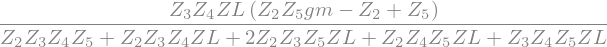

In [313]:
# myBaseTF.setT_type("some_parasitic")
myBaseTF.solve()

In [314]:
experiment = SymbolixExperiment(myBaseTF)

In [315]:
experiment.getComboKeys()


dict_keys(['all', 'Z3_ZL', 'Z5_ZL', 'Z2_Z4_ZL', 'Z2_Z5_ZL', 'Z3_Z5_ZL'])

In [316]:
tfs, zBatch = experiment.compute("Z5_ZL")

Getting the TFs (CG): 100%|██████████| 121/121 [00:05<00:00, 23.93combo/s]

Number of transfer functions found: 121
H(s) 1: RL*(R4*gm - 1)/(R4 + RL)
H(s) 2: LL*s*(R4*gm - 1)/(LL*s + R4)
H(s) 3: (R4*gm - 1)/(CL*R4*s + 1)
H(s) 4: RL*(R4*gm - 1)/(CL*R4*RL*s + R4 + RL)
H(s) 5: (R4*gm - 1)*(CL*RL*s + 1)/(CL*R4*s + CL*RL*s + 1)
H(s) 6: (R4*gm - 1)*(CL*LL*s**2 + 1)/(CL*LL*s**2 + CL*R4*s + 1)
H(s) 7: LL*s*(R4*gm - 1)/(CL*LL*R4*s**2 + LL*s + R4)
H(s) 8: (R4*gm - 1)*(CL*LL*s**2 + CL*RL*s + 1)/(CL*LL*s**2 + CL*R4*s + CL*RL*s + 1)
H(s) 9: LL*RL*s*(R4*gm - 1)/(CL*LL*R4*RL*s**2 + LL*R4*s + LL*RL*s + R4*RL)
H(s) 10: (R4*gm - 1)*(CL*LL*RL*s**2 + LL*s + RL)/(CL*LL*R4*s**2 + CL*LL*RL*s**2 + LL*s + R4 + RL)
H(s) 11: RL*(R4*gm - 1)*(CL*LL*s**2 + 1)/(CL*LL*R4*s**2 + CL*LL*RL*s**2 + CL*R4*RL*s + R4 + RL)
H(s) 12: RL*(L4*gm*s - 1)/(L4*s + RL)
H(s) 13: LL*(L4*gm*s - 1)/(L4 + LL)
H(s) 14: (L4*gm*s - 1)/(CL*L4*s**2 + 1)
H(s) 15: RL*(L4*gm*s - 1)/(CL*L4*RL*s**2 + L4*s + RL)
H(s) 16: (CL*RL*s + 1)*(L4*gm*s - 1)/(CL*L4*s**2 + CL*RL*s + 1)
H(s) 17: (CL*LL*s**2 + 1)*(L4*gm*s - 1)/(CL*L4*s**

In [317]:
classifier = FilterClassifier(tfs, zBatch)

In [318]:
classifier.countTF()
classifier.classifyBiQuadFilters()
[classification for classification in classifier.classifications if classification.valid]

Computing filter parameters: 100%|██████████| 121/121 [00:01<00:00, 72.84filter/s]


[FilterClassification(zCombo=(oo, oo, oo, oo, R4, LL*s + 1/(CL*s)), transferFunc=(R4*gm - 1)*(CL*LL*s**2 + 1)/(CL*LL*s**2 + CL*R4*s + 1), valid=True, fType=BS, parameters={'Q': LL*sqrt(1/(CL*LL))/R4, 'wo': sqrt(1/(CL*LL)), 'bandwidth': R4/LL, 'K_LP': R4*gm - 1, 'K_HP': R4*gm - 1, 'K_BP': 0, 'Qz': None}),
 FilterClassification(zCombo=(oo, oo, oo, oo, R4, LL*s/(CL*LL*s**2 + 1)), transferFunc=LL*s*(R4*gm - 1)/(CL*LL*R4*s**2 + LL*s + R4), valid=True, fType=BP, parameters={'Q': CL*R4*sqrt(1/(CL*LL)), 'wo': sqrt(1/(CL*LL)), 'bandwidth': 1/(CL*R4), 'K_LP': 0, 'K_HP': 0, 'K_BP': R4*gm - 1, 'Qz': 0}),
 FilterClassification(zCombo=(oo, oo, oo, oo, R4, LL*s + RL + 1/(CL*s)), transferFunc=(R4*gm - 1)*(CL*LL*s**2 + CL*RL*s + 1)/(CL*LL*s**2 + CL*R4*s + CL*RL*s + 1), valid=True, fType=GE, parameters={'Q': LL*sqrt(1/(CL*LL))/(R4 + RL), 'wo': sqrt(1/(CL*LL)), 'bandwidth': (R4 + RL)/LL, 'K_LP': R4*gm - 1, 'K_HP': R4*gm - 1, 'K_BP': RL*(R4*gm - 1)/(R4 + RL), 'Qz': LL*sqrt(1/(CL*LL))/RL}),
 FilterClassifi

In [319]:
classifier.summarizeFilterType()
classifier.classifications[0]

HP : 0
BP : 2
LP : 0
BS : 2
GE : 11
AP : 0


FilterClassification(zCombo=(oo, oo, oo, oo, R4, RL), transferFunc=RL*(R4*gm - 1)/(R4 + RL), valid=False, fType=None, parameters=None)

In [342]:
Utils().generateLaTeXReport(classifier.clusteredByType["BP"])

LaTeX report saved to: Outputs/Report.tex


In [321]:
classifier.clusteredByType["BP"][0].valid

True

## Printing the Results